# Task

The notebook aims to develop a fruit classification and freshness prediction system using machine learning techniques. The goal is to accurately classify the name of a given fruit and predict its freshness based on available data. Since we are prediction two different types of classes (name and freshness), hence the neural network needs to be multi output. 

# Use Case

1. **Grocery Shopping**: Consumers can use the system's mobile application to identify and verify the name and freshness of fruits before purchasing them, ensuring they make informed decisions and select the freshest options.

2. **Inventory Management**: Fruit vendors and supermarkets can utilize the system to automatically classify fruits and assess their freshness upon arrival. This helps in efficient inventory management, enabling them to prioritize the sale of fresh fruits and minimize waste.

3. **Quality Control** in Food Processing: Food processing companies can integrate the system into their production lines to ensure consistent quality of fruit-based products. By verifying the fruit type and freshness, they can maintain high-quality standards throughout the manufacturing process.

4. **Restaurant and Catering Services**: Chefs and caterers can benefit from the system to ensure they select the right fruits for their dishes. They can quickly identify the fruit type and freshness, enabling them to create flavorful and visually appealing meals.

**This notebook can also help learn more about PyTorch and building complex architectures using it.**


# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea
from tqdm.notebook import tqdm
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F
import torchmetrics
from torchmetrics import Metric
import torchvision
from torchvision import models
import cv2 as op

plt.style.use('seaborn')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

np.__version__, device

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

('1.23.5', 'cuda')

# Loading the data

In [2]:
TRAIN_PATH = '/kaggle/input/fresh-and-stale-classification/dataset/Train'
TEST_PATH = '/kaggle/input/fresh-and-stale-classification/dataset/Test'

def load_data(PATH):
    filenames, fruit, fresh = [], [], []
    
    for file in tqdm(os.listdir(PATH)):
        for img in os.listdir(os.path.join(PATH, file)):
            fresh.append(0 if file[0] == 'f' else 1)
            fruit.append(file[5:] if file[0] == 'f' else file[6: ])
            filenames.append(os.path.join(PATH, file, img))
            
    df = pd.DataFrame({
        'filename' : filenames,
        'fruit' : fruit,
        'fresh' : fresh
    })
    
    return df

df_train = load_data(TRAIN_PATH).sample(frac = 1)
df_test = load_data(TEST_PATH).sample(frac = 1)

df_train.shape, df_test.shape
    

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

((23619, 3), (6738, 3))

In [3]:
df_train.drop(df_train[(df_train['fruit'] == 'capsicum') & (df_train['fruit'] == 'bittergourd')].index, inplace = True)
df_test['fruit'] = df_test['fruit'].map(lambda x : 'tomato' if x == 'tamto' else x)
df_test['fruit'] = df_test['fruit'].map(lambda x : 'potato' if x == 'patato' else x)

In [4]:
df = pd.concat([df_train, df_test], axis = 0)
df.shape

(30357, 3)

## Data distribution

It can be observed that the dataset is highly imbalanced. Instances of apples and banana are much more than that of other fruits. I tried some ways to get around this but it couldn't solve the data imbalance problem. Finally, what I did was merged both of the training and testing data and for each fruit having more than 1500 images, I sampled out exactly 1500 out of it and saved it in new dataframe. Frutis having less than 1500 images where kept as it is. 

1. This made sure the dataset is somewhat balanced.
2. While discarding a significant number of images, particularly those of apples and bananas, might initially appear as wasteful, I firmly believe that curating a well-balanced dataset can substantially enhance the quality of results obtained, making the effort of removing excess images worthwhile.

<Axes: xlabel='fruit', ylabel='count'>

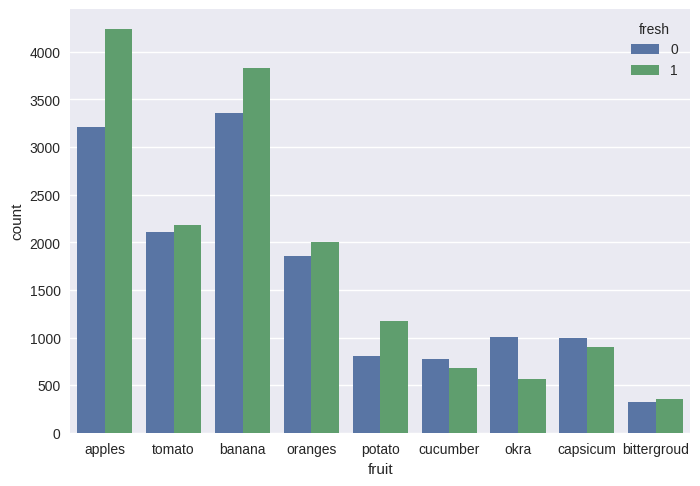

In [5]:
sea.countplot(x = 'fruit', data = df, hue = 'fresh')

## New balanced dataset

In [6]:
counts = df['fruit'].value_counts()
df_new = pd.DataFrame(columns= ['filename', 'fruit', 'fresh'])

for (key, value) in counts.items():
    if value > 1500:
        df_temp = df[df['fruit'] == key].sample(n = 1500)
    else:
        df_temp = df[df['fruit'] == key]
        
    df_new = pd.concat([df_new, df_temp], axis = 0)  
    
df_new.shape

(12635, 3)

In [7]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

df_new['fruit_label'] = le.fit_transform(df_new['fruit'])
df_new.shape

(12635, 4)

In [8]:
df_new.head()

,filename,fruit,fresh,fruit_label
20373,/kaggle/input/fresh-and-stale-classification/d...,apples,0,0
6435,/kaggle/input/fresh-and-stale-classification/d...,apples,0,0
5889,/kaggle/input/fresh-and-stale-classification/d...,apples,0,0
20593,/kaggle/input/fresh-and-stale-classification/d...,apples,0,0
17311,/kaggle/input/fresh-and-stale-classification/d...,apples,1,0


<Axes: xlabel='fruit', ylabel='count'>

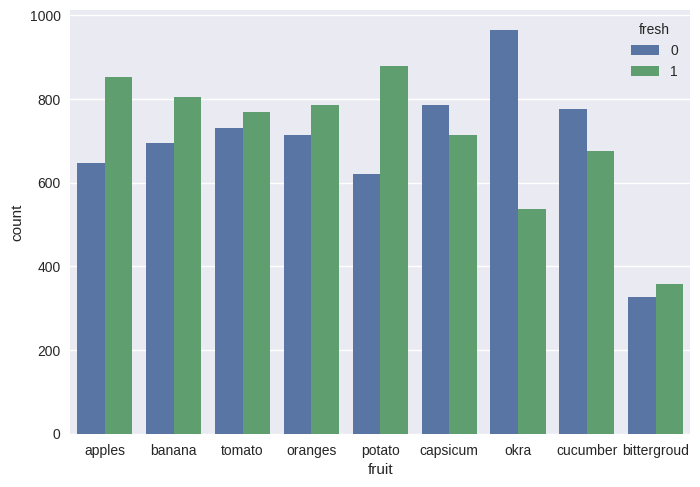

In [9]:
sea.countplot(x = 'fruit', data = df_new, hue = 'fresh')

## Creating training and validation split

15% of the data was used for validation while the remaining for training.

In [10]:
from sklearn.model_selection import train_test_split

df_train, df_val = train_test_split(df_new, test_size = 0.15, stratify = df_new['fruit_label'])

df_train.shape, df_val.shape

((10739, 4), (1896, 4))

<Axes: xlabel='fruit_label', ylabel='count'>

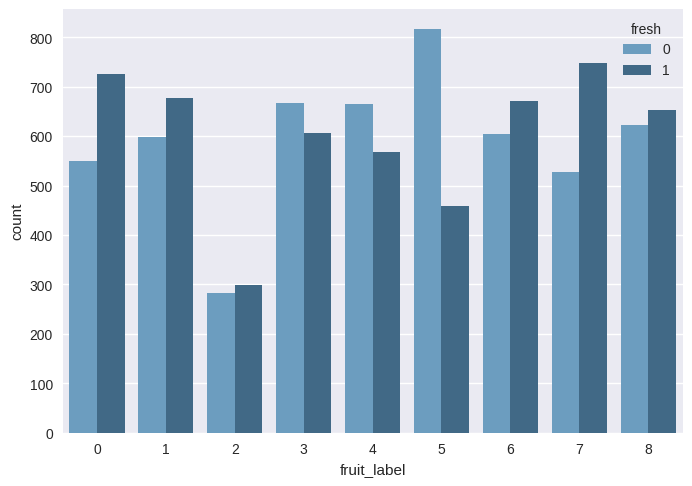

In [11]:
sea.countplot(x = 'fruit_label', data = df_train, hue = 'fresh', palette = 'Blues_d')

<Axes: xlabel='fruit', ylabel='count'>

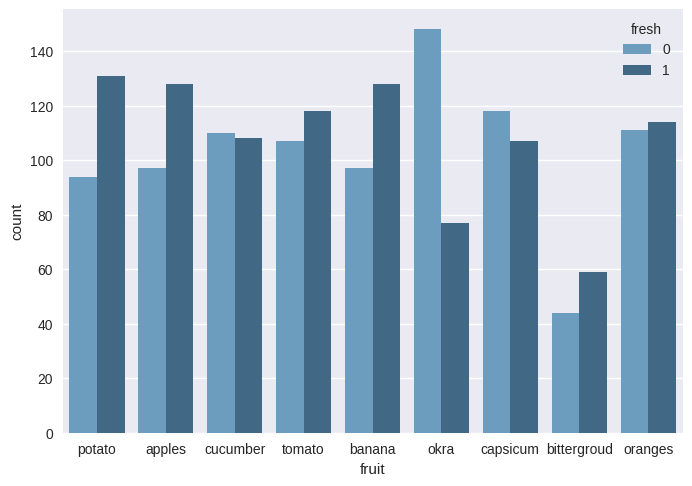

In [12]:
sea.countplot(x = 'fruit', data = df_val, hue = 'fresh', palette = 'Blues_d')

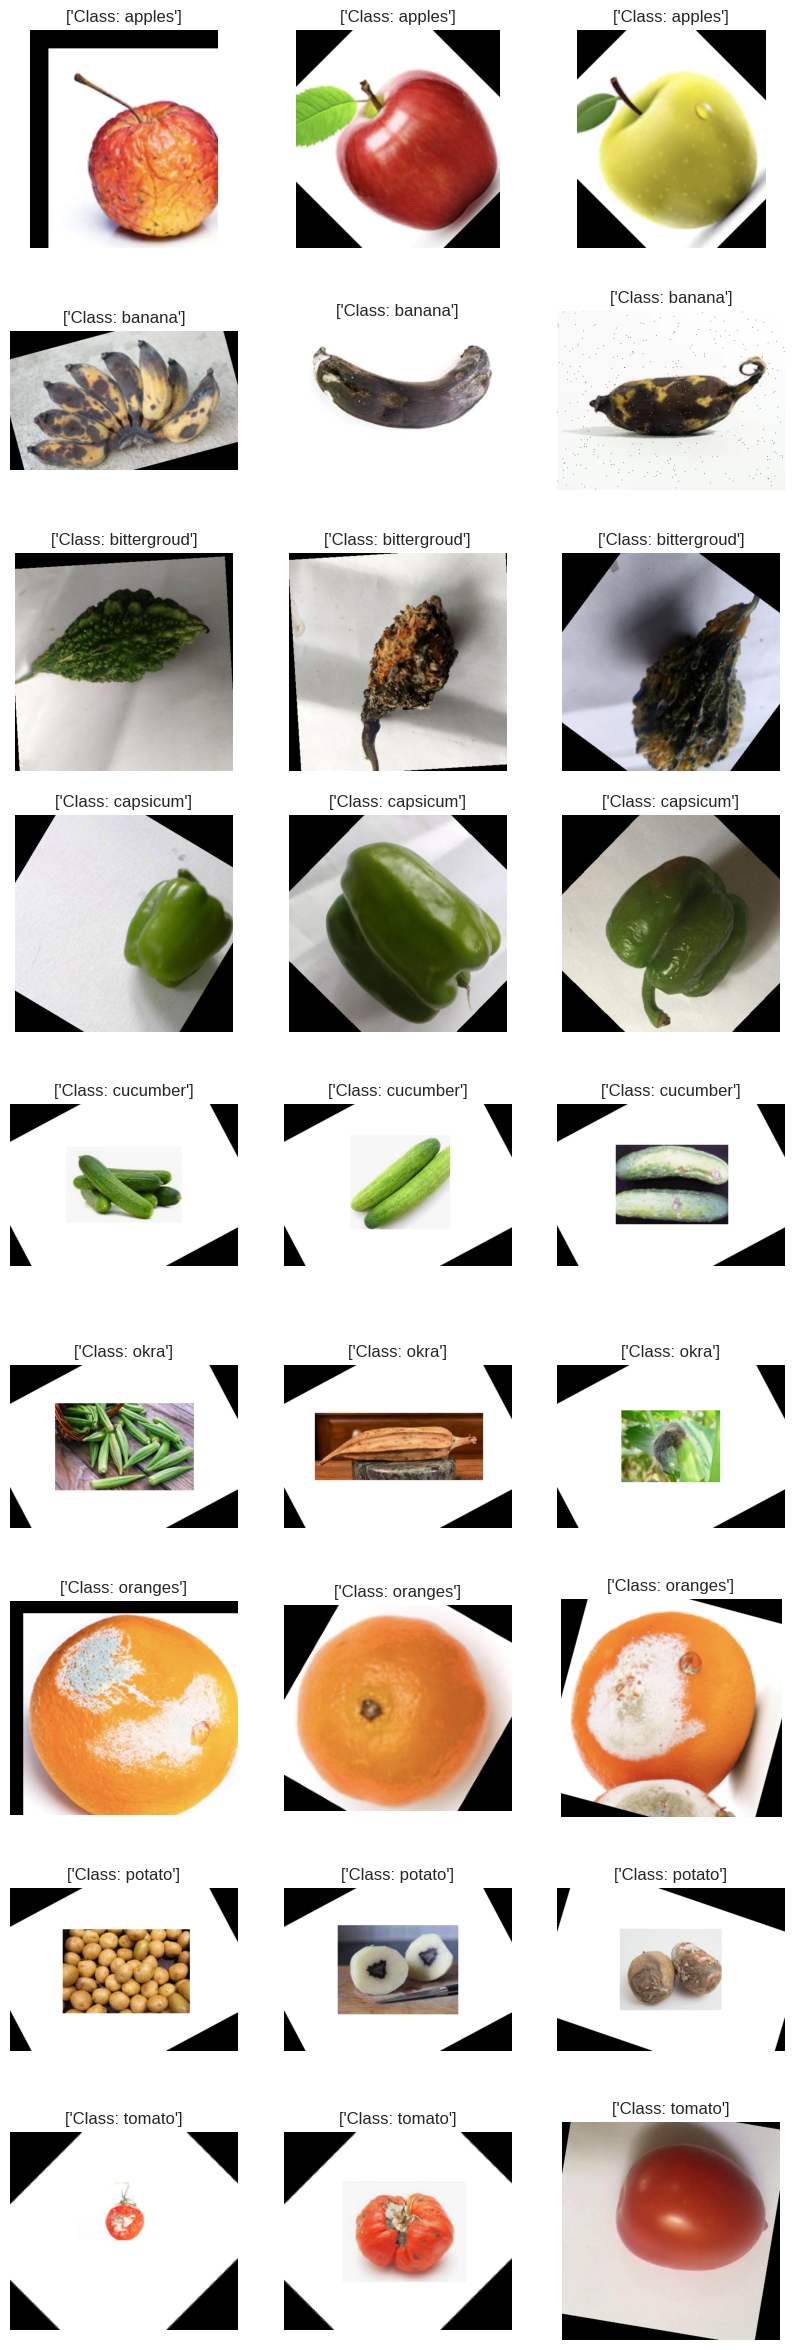

In [13]:
def load_image(path):
    img = plt.imread(path)
    return img

counter = 0

plt.figure(figsize = (10, 30))

for i in range(9):
    for path in df_train[df_train['fruit_label'] == i].sample(n = 3)['filename']:
        plt.subplot(9, 3, counter + 1)
        img = load_image(path)
        plt.imshow(img)
        plt.axis('off')
        plt.title('Class:' + " " + le.inverse_transform([i]))
        counter += 1
        
plt.show()

# Building the dataset

1. The dataset was building using torch.utils.data.Dataset for efficinet loading of data.
2. For data augmentation, Random Horizontal, GaussianBlur and RandomAdjustSharpness was used. The images were resized to 224x224.
3. Batch Size = 64.

In [14]:

def image_transform(img, p = 0.5, training = True):    
    if training:
        img = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(p = p),
            transforms.GaussianBlur(3, sigma=(0.1, 2.0)),
            transforms.RandomAdjustSharpness(3, p = p),
            transforms.Normalize(mean = 0, std = 1)
        ])(img)
    else:
        img = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224, 224)),
            transforms.Normalize(mean = 0, std = 1)
        ])(img)

    return img

class FruitDataset:
    def __init__(self, df, training):
        self.df = df
        self.n_samples = len(self.df)
        self.training = training
        
    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, idx):
        img = plt.imread(self.df.iloc[idx][0])[:, :, :3]
        fresh = torch.tensor(self.df.iloc[idx][2])
        fruit = torch.tensor(self.df.iloc[idx][3])

        img = image_transform(img, p = 0.5, training = self.training)
            
        return img, fruit, fresh
    

In [15]:
BATCH_SIZE = 64


train_dataset = FruitDataset(df_train, training = True)
val_dataset = FruitDataset(df_val, training = False)

train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE)


In [16]:
a, b, c = next(iter(train_loader))
print(a.shape, b.shape, c.shape)
del(a)
del(b)
del(c)

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:152: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array 

torch.Size([64, 3, 224, 224]) torch.Size([64]) torch.Size([64])


# Model Architecture

1. Resnet18 pretrained model for this task.

2. ResNet-18 is composed of multiple residual blocks, which are designed to address the problem of vanishing gradients in deep neural networks. These blocks introduce skip connections, allowing information to bypass several layers and flow directly to deeper layers. This helps in mitigating the degradation problem and enables the network to learn more effectively, even with very deep architectures.

3. The last layer of the restnet18 was replaced with two dense layers and the output was sent to two branches, first branch predicting the name of the fruit while the other branch predicting if the fruit is fresh or not.

4. The Last 15 layers of the resnet18 was made trainable and reamining layers were freezed.

5. For the loss calculation, a weighted combination of the losses from both the branches were taken. ($\alpha=0.7$). This idea is just an expriment and we can try experimenting with different values of $\alpha$.

    $L_{total} = \alpha * L_{1} + (1 - \alpha) * L_{2}$

![model](https://i.postimg.cc/SsP2zk9W/model.png)

In [17]:
import math

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.alpha = 0.7
        
        self.base = torchvision.models.resnet18(pretrained = True)
        
        for param in list(self.base.parameters())[:-15]:
            param.requires_grad = False
                    
        self.base.classifier = nn.Sequential()
        self.base.fc = nn.Sequential()
            
        self.block1 = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
        )
        
        self.block2 = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 9)
        )
        
        self.block3 = nn.Sequential(
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, 2)
        )

        self.optimizer1 = torch.optim.Adam([
            {'params' : self.base.parameters(), 'lr': 1e-5},
            {'params' : self.block1.parameters(),  'lr': 3e-4}
        ])
        
        self.optimizer2 = torch.optim.Adam(self.block2.parameters(), lr = 3e-4)
        self.optimizer3 = torch.optim.Adam(self.block3.parameters(), lr = 3e-4)
        
        self.loss_fxn = nn.CrossEntropyLoss()
        self.fruit_accuracy = torchmetrics.Accuracy(task='multiclass', num_classes = 9)
        self.fresh_accuracy = torchmetrics.Accuracy(task = 'multiclass', num_classes = 2)
        
        self.TRAIN_BATCHES = math.ceil(len(train_dataset)/BATCH_SIZE)
        self.VAL_BATCHES = math.ceil(len(val_dataset)/BATCH_SIZE)

        self.history = {'train_loss': [], 'val_loss': [], 
                    'train_acc_fruit': [], 'train_acc_fresh': [],
                    'val_acc_fruit': [], 'val_acc_fresh': []}
    
        
    def forward(self, x):
        x = self.base(x)
        x = self.block1(x)
        y1, y2 = self.block2(x), self.block3(x)
        
        return y1, y2

    
    def train_step(self, x, y1, y2):
        pred1, pred2 = self.forward(x)
        l1, l2 = self.loss_fxn(pred1, y1), self.loss_fxn(pred2, y2)

        self.optimizer2.zero_grad()
        l1.backward(retain_graph = True)
        self.optimizer2.step()
        
        self.optimizer3.zero_grad()
        l2.backward(retain_graph = True)
        self.optimizer3.step()
        
        
        loss = self.alpha * l1 + (1 - self.alpha) * l2
        self.optimizer1.zero_grad()
        loss.backward()
        self.optimizer1.step()
        
        fruit_acc = self.fruit_accuracy(torch.argmax(pred1, axis = 1), y1)
        fresh_acc = self.fresh_accuracy(torch.argmax(pred2, axis = 1), y2)
        
        return loss, fruit_acc, fresh_acc
    
    def val_step(self, x, y1, y2):
        with torch.no_grad():
            pred1, pred2 = self.forward(x)
            loss = self.alpha * self.loss_fxn(pred1, y1) + (1 - self.alpha) * self.loss_fxn(pred2, y2)

            fruit_acc = self.fruit_accuracy(torch.argmax(pred1, axis = 1), y1)
            fresh_acc = self.fresh_accuracy(torch.argmax(pred2, axis = 1), y2)
            return loss, fruit_acc, fresh_acc
        
    def update_history(self, train_loss, train_fruit, train_fresh, val_loss, val_fruit, val_fresh):
        self.history['train_loss'].append(train_loss)
        self.history['val_loss'].append(val_loss)
        self.history['train_acc_fresh'].append(train_fresh)
        self.history['train_acc_fruit'].append(train_fruit)
        self.history['val_acc_fresh'].append(val_fresh)
        self.history['val_acc_fruit'].append(val_fruit)
        
        
    def train(self, epochs = 5):
        
        for epoch in tqdm(range(epochs)):
            
            train_loss, train_fruit, train_fresh = 0, 0, 0
            val_loss, val_fruit, val_fresh = 0, 0, 0
            
            for X, y1, y2 in tqdm(train_loader):
                X, y1, y2 = [v.to(device) for v in (X, y1, y2)]
                loss, fruit_acc, fresh_acc = self.train_step(X, y1, y2)
                train_loss += loss.item()
                train_fruit += fruit_acc.item()
                train_fresh += fresh_acc.item()
                
            for X, y1, y2 in tqdm(val_loader):
                X, y1, y2 = [v.to(device) for v in (X, y1, y2)]
                loss, fruit_acc, fresh_acc = self.val_step(X, y1, y2)
                val_loss += loss.item()
                val_fruit += fruit_acc.item()
                val_fresh += fresh_acc.item()
                
            train_loss, train_fruit, train_fresh = [x/self.TRAIN_BATCHES for x in (train_loss, train_fruit, train_fresh)]
            val_loss, val_fruit, val_fresh = [x/self.VAL_BATCHES for x in (val_loss, val_fruit, val_fresh)]
            
            self.update_history( train_loss, train_fruit, train_fresh, val_loss, val_fruit, val_fresh)
            
            print("[Epoch: {}] Train: [loss: {:.3f}, fruit: {:.3f} fresh: {:.3f}] Val: [loss: {:.3f}, fruit: {:.3f} fresh: {:.3f}]".format(epoch, train_loss, train_fruit, train_fresh, 
                                                                                                                                          val_loss, val_fruit, val_fresh))


In [18]:
model = Model().to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 269MB/s]


# Training the model

In [ ]:
model.train(epochs = 6)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/168 [00:00<?, ?it/s]

In [ ]:
torch.save(model.state_dict(), "fresh_stale_model.pth")

# Plotting Model Results

In [ ]:
plt.figure(figsize = (16, 4))

plt.subplot(1,3,1)
plt.title('Loss')
plt.plot(model.history['train_loss'], label = 'Training')
plt.plot(model.history['val_loss'], label = 'Validation')
plt.legend()

plt.subplot(1,3,2)
plt.title('Fruit Name Accuracy')
plt.plot(model.history['train_acc_fruit'], label = 'Training')
plt.plot(model.history['val_acc_fruit'], label = 'Training')
plt.legend()

plt.subplot(1,3,3)
plt.title('Freshness Accuracy')
plt.plot(model.history['train_acc_fresh'], label = 'Training')
plt.plot(model.history['val_acc_fresh'], label = 'Training')
plt.legend()


# Model Predictions

In [ ]:
preds1, preds2, fruit, fresh = [], [], [], []

with torch.no_grad():
    for x, y1, y2 in tqdm(val_loader):
        pred = model(x.to(device))
        
        pred1 = torch.argmax(pred[0], axis = 1).detach().cpu().numpy()
        pred2 = torch.argmax(pred[1], axis = 1).detach().cpu().numpy()
        preds1.extend(pred1)
        preds2.extend(pred2)
        fruit.extend(y1)
        fresh.extend(y2)
        
        
len(fruit), len(fresh), len(preds1), len(preds2)

In [ ]:
from sklearn.metrics import confusion_matrix

class_names = le.inverse_transform(np.arange(0, 9))

cm = confusion_matrix(fruit, preds1)
sea.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, xticklabels = class_names, yticklabels = class_names)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Fruit Names')

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(fresh, preds2)
sea.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, xticklabels = ['Fresh', 'Spoiled'], yticklabels = ['Fresh', 'Spoiled'])

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Freshness')

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(fruit, preds1, target_names = class_names))
print(classification_report(fresh, preds2, target_names = ['Fresh', 'Spoiled']))

# Conclusion

1. The classification report shows how well the fruit classification model performed. Overall, the model did really well with high scores for most of the fruits. It achieved an accuracy of 0.98, which means it predicted the correct fruit in nearly 98% of cases. The macro average scores were also impressive, with precision, recall, and F1-score all around 0.99. This means the model performed consistently across all fruit classes, regardless of class imbalance. The weighted average scores took into account the number of instances for each fruit and were still quite good, all at 0.98.

2. The next classification report shows how well the model performed in differentiating between fresh and spoiled fruits. With an accuracy of 0.98, the model correctly classified fruits in nearly 98% of cases. The precision, recall, and F1-scores for both classes were around 0.98, indicating consistent and accurate predictions. Overall, our model demonstrated strong performance in distinguishing between fresh and spoiled fruits, achieving high accuracy and precision.
